<a href="https://colab.research.google.com/github/rstager/ARoboCar/blob/master/pytorch_tutorial1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the environment

In [0]:
from __future__ import print_function
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import copy
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import math
from mpl_toolkits.mplot3d import Axes3D
from functools import partial



East Bay Machine Learning pytorch tutorial series.

---

This is the second part of the pytorch tutorial series first meeting.


We willl used a google doc as a shared online clipboard. 
https://docs.google.com/document/d/1N-5Ue0rk7g8CImayet-cgnaCkHJzXky7aeHrwUocXEM/edit?usp=sharing


#Agenda

* in the section we will explore torch.nn

Lets get *started*

* first bring a few of our utility functions from the previous notebook

In [0]:
# just run on cpu for now
device="cpu"

# Data Generation
def dataset_from_function_with_noise(f,npoints=100,noise=0.1,device="cpu"):
  torch.manual_seed(42)
  x_train_tensor = torch.rand((npoints,1),device=device)
  y_train_tensor = f(x_train_tensor)
  y_train_tensor += torch.randn(y_train_tensor.shape)*noise
  return x_train_tensor,y_train_tensor

class Movie:
  def __init__(self,X,Y,rng=None,axis=None):
    self.X=X.cpu()
    self.Y=Y.cpu()
    self.axis=plt.gca() if axis is None else axis
    self.scat=self.axis.scatter(self.X,self.Y,c='b')
    self.artists=[]
    self.rng=torch.linspace(min(self.X).item(),max(self.X).item(),100).unsqueeze(-1) if rng is None else rng


  def __call__(self,model):
    l1,=self.axis.plot(list(self.rng),list(model(self.rng)),c='r')
    self.artists.append([self.scat,l1])    


def plot_hook(model,X,Y):
  if X is not None:
    plt.scatter(X.cpu(),Y.cpu(),c='b')
  plt.plot(list(rng),list(model(rng)),c='r')
  plt.pause(0.5)
  clear_output()

# Create our dataset

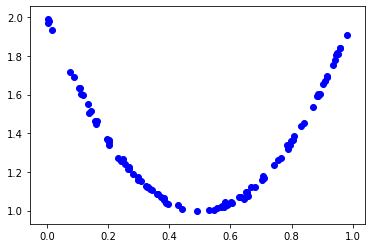

In [3]:
torch.manual_seed(42)
X_train,Y_train = dataset_from_function_with_noise(lambda x:1 + 4 * (x-0.5)**2,noise=0.01 ,npoints=100 )
plt.scatter(X_train,Y_train,c='b')
plt.show()

# OK. Lets play with pytorch.nn
* torch.Tensor is like numpy
* torch.nn,torch.optim,torch.loss,torch.data are like keras

* torch.nn.Model is a container for parameters (torch.nn.Parameters) and a forward(x) function. It may also include additional sub models.
https://pytorch.org/docs/stable/nn.html


Thanks to 
https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379 for the example.

First we will do a quick implementation of the network that we finished with in the previous notebook, and then we will do a deeper dive into the libraries

In [0]:
def initializer(model):
  for p in model.parameters():
    try:
      torch.nn.init.kaiming_uniform_(p, a=math.sqrt(5))
    except:
      torch.nn.init.uniform_(p)

def sgd(model,data_loader,criterion,optimizer,n_epochs=100,hook=lambda m,x,y,l:None,
        initialize=initializer):
  initialize(model)
  for i in range(n_epochs):
    for X,Y in my_dataloader:
      Yhat = model(X)
      loss = criterion(Yhat, Y)
      optimizer.zero_grad()   # zero the gradient buffers
      loss.backward()
      optimizer.step()    # Does the update
    hook(model)

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


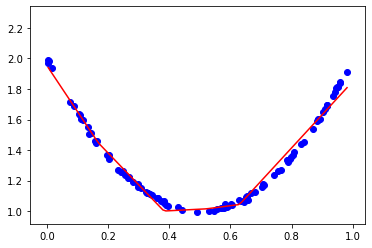

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

my_dataset = data.TensorDataset(X_train,Y_train) # create your datset
my_dataloader = data.DataLoader(my_dataset,batch_size=64) 

torch.manual_seed(42)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
print(net)

criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(),lr=1e-2,nesterov=True,momentum=1e-10)
optimizer = optim.Adam(net.parameters(), lr=0.1)

fig, ax = plt.subplots()

torch.manual_seed(42)
movie=Movie(X_train,Y_train)
sgd(net,my_dataloader,criterion,optimizer,hook=movie)
HTML(animation.ArtistAnimation(fig, movie.artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# Let's dive into the libraries a little

optimizers (to be explored in later session) :https://pytorch.org/docs/stable/optim.html [SGD source ](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD)


loss functions: https://pytorch.org/docs/stable/nn.functional.html#loss-functions

torch functions: https://pytorch.org/docs/stable/nn.functional.html

data utilities: (to be explored in later session) https://pytorch.org/docs/stable/data.html


* [torch.utils.data](https://pytorch.org/docs/stable/data.html)
* [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#linear)  [F.linear](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#linear)
* [torch.functional.relu](https://)
* [torch.optim](https://pytorch.org/docs/master/optim.html)

# Now your turn.

Play with optimizers, loss functions,learning rate, target signal, target noise, # points, batchsize, epochs ,model structure, etc. Try it on a GPU.

Find an interesting result and post it to the shared board. Try to keep training time down so we can share during class.

# Loss surface of high dimensionality parameter space

With the dimensionality of the parameter space dimensionality larger than 2, we can no longer create an intuitive loss surface representation. A proxy is to take a number of 1 dimensional slices in random directions in the N dimensional space around a point in the parameters space. This does not give us a view of the entire surface, but gives us a sense of the curvature at that point.

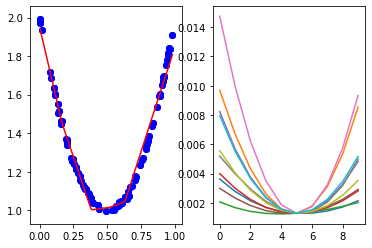

In [6]:
torch.manual_seed(42)
def slicemodel(model, nslices=10,magitude=1):  # generate n random vectors in the paramater space of model
  lr=0.1
  with torch.no_grad():
    slices = [[torch.randn_like(p)*lr  for p in model.parameters(recurse=True)] for n in range(10)]
    # todo: each vector should be magnitude length
    return slices

def slicelosses(slices,model,X,Y,criterion,npoints=10):
  losses=[]
  for slice in slices:
    loss=[]
    for tmp in range(0,npoints):
      factor=(tmp-npoints/2)/npoints
      # perturb the model parameters in direction of the slice
      workingmodel=copy.deepcopy(model)
      with torch.no_grad():     
        workingmodel.requires_grad=False
        for p,slicep in zip(workingmodel.parameters(recurse=True),slice):
          p.add_(slicep*factor)
        Yhat = workingmodel(X)
        loss.append(criterion(Yhat, Y))
    losses.append(loss)
  return losses

class SliceMovie(Movie):
  def __init__(self,model,criterion,X,Y,axes=None,slices=None):
    self.axes=axes if axes is not None else [plt.subplot(121),plt.subplot(122)]
    super().__init__(X,Y,axis=self.axes[0])
    self.model=model
    self.criterion=criterion
    self.slices=slicemodel(self.model, nslices=10,magitude=1) if slices is None else slices
    self.scat=self.axes[0].scatter(X.cpu(),Y.cpu(),c='b')

  def __call__(self,model):
    l1,=self.axes[0].plot(list(self.rng),list(model(self.rng)),c='r')
    a2=[l1]
    for loss in slicelosses(self.slices,model,self.X,self.Y,self.criterion):
      a2.append(self.axes[1].plot(loss)[0])
    self.artists.append(a2)
    
def slice_movie_hook(model,X,Y):
  global criterion,slices,artists,slice_axes
  scat=slice_axes[0].scatter(X.cpu(),Y.cpu(),c='b')
  l1,=slice_axes[0].plot(list(rng),list(model(rng)),c='r')
  artists.append([scat,l1]+[slice_axes[1].plot(loss)[0] for loss in slicelosses(slices,model,X,Y,None)])

movie=SliceMovie(net,criterion,X=X_train,Y=Y_train)
movie(net)
plt.pause(1)

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


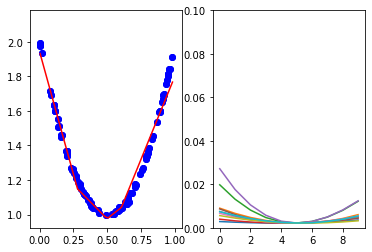

In [7]:
torch.manual_seed(42)
torch.manual_seed(60)
net = Net()
print(net)

fig, ax = plt.subplots()
optimizer = optim.Adam(net.parameters(), lr=0.05)
#optimizer = optim.SGD(net.parameters(),lr=2e-1)#,nesterov=True,momentum=1e-10)
slices=slicemodel(net,30)

movie=SliceMovie(net,criterion,X=X_train,Y=Y_train,slices=slices)
movie.axes[1].set_ylim(0,0.1)
torch.manual_seed(42)
sgd(net,my_dataloader,criterion,optimizer,hook=movie,n_epochs=100)
HTML(animation.ArtistAnimation(fig, movie.artists,interval=50, blit=True,repeat_delay=1000).to_html5_video()) 

# Question

Why doesnt the linear model above use all of the hidden layer activations to make a closer fit?

* I tried 3000 epoch and it never improved

## Links and stuff




https://pytorch.org/docs/master/named_tensor.html
https://en.wikipedia.org/wiki/Automatic_differentiation
https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/module.py
https://www.analyticsvidhya.com/blog/2019/09/introduction-to-pytorch-from-scratch/
https://blog.paperspace.com/pytorch-101-advanced/




In [0]:
import time
import numpy as np
def pltit(recorder,name,c):
  plt.title(name)
  for name in [name]:
    tl=[t.detach().numpy() for t in recorder[name]]
    print("len(tl) ",len(tl)," shape ",name," ",tl[0].shape)
    if len(tl[0].shape)==2:
      if tl[0].shape[1]==1:
        v=np.hstack(tl) 
        print("first v shape ",v.shape)          
        print("tl[0] shape",tl[0].shape)  
      elif tl[0].shape[0]==1:
        v=np.hstack([t.detach().numpy().T for t in recorder[name]])
        print("other v shape ",v.shape)
      else:
        v=np.hstack([t.detach().numpy().T for t in recorder[name]])[:,::10]
        print("v shape ",v.shape)
        print("v[:2,:10] ",v[:2,:10])
        print("tl[0] shape",tl[0].shape)        
    elif len(tl[0].shape)==1:
      v=np.hstack([np.expand_dims(t.detach().numpy(), axis=-1) for t in recorder[name]])
      print("one v shape ",v.shape)
    else:
      print("unexpected shape",tl[0].shape) 
    for l in v:
      plt.plot(l,c=c,label=name)

def pltresults(recorder):
  print(recorder.shape)
  fig= plt.figure(figsize=(20,10))
  for idx,trace in enumerate( ['w1','w2','b1','b2','w1.grad','w2.grad','b1.grad','b2.grad']):
    c='r' if '2' in trace else 'b'
    plt.subplot(2,4,idx+1)
    pltit(recorder,trace,c)

  plt.pause(1)
  fig= plt.figure(figsize=(20,10))
  plt.subplot(2,1,1)
  pltit(recorder,'h1','b')
  plt.subplot(2,1,2)
  pltit(recorder,'h2','r')
  plt.pause(1)
